In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

## Even slightly noisy data makes derivatives extremely noisy

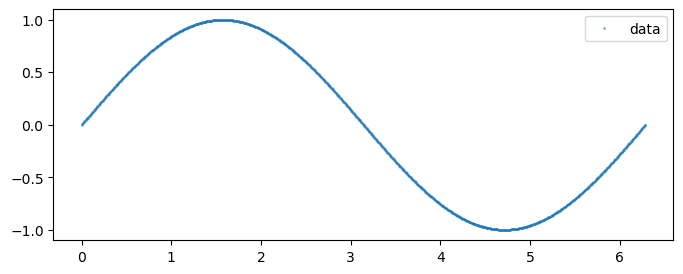

In [2]:
# generate some data of a sine wave
x = torch.linspace(0, 2 * np.pi, 1000)
y = torch.sin(x)

# plot the data
plt.figure(figsize=(8, 3))
plt.plot(x, y, 'o', label='data', markersize=1, alpha=0.5)
plt.legend()
plt.show()

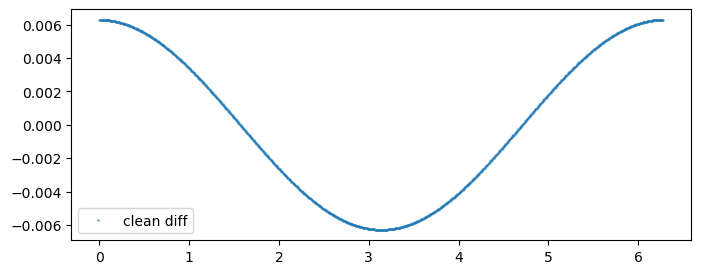

In [3]:
y_diff = y[1:] - y[:-1]

plt.figure(figsize=(8, 3))
plt.plot(x[:-1], y_diff, 'o', label='clean diff', markersize=1, alpha=0.5)
plt.legend()
plt.show()

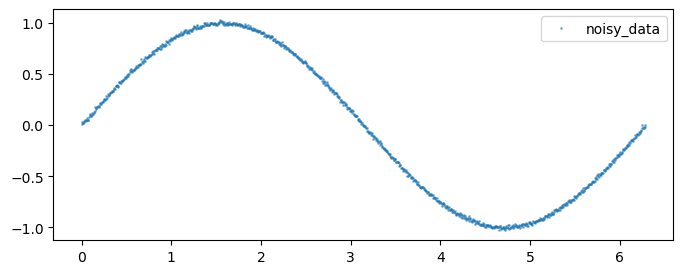

In [4]:
y_noise = y + torch.randn_like(y) * 0.01

# plot the data
plt.figure(figsize=(8, 3))
plt.plot(x, y_noise, 'o', label='noisy_data', markersize=1, alpha=0.5)
plt.legend()
plt.show()

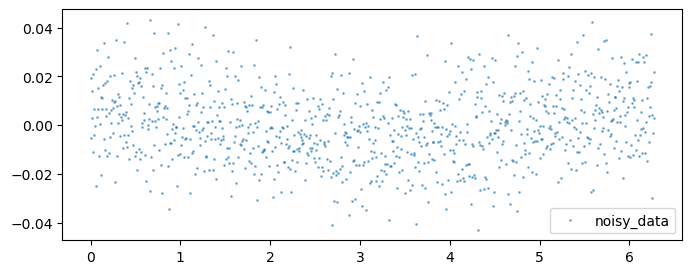

In [5]:
noise_diff = y_noise[1:] - y_noise[:-1]

plt.figure(figsize=(8, 3))
plt.plot(x[:-1], noise_diff, 'o', label='noisy_data', markersize=1, alpha=0.5)
plt.legend()
plt.show()

## Convolution Smoothing

In [6]:
# interpolate the data
t = torch.linspace(0, 2 * np.pi, 1000)
x_clean = torch.sin(t)
x_clean = x_clean.reshape(1, 1, -1)
# make x noisy and 1000 by 1
x = torch.sin(t) + torch.randn_like(t) * 0.01
# reshape x to 1 by 1 by 1000
x = x.reshape(1, 1, -1)
x.shape

torch.Size([1, 1, 1000])

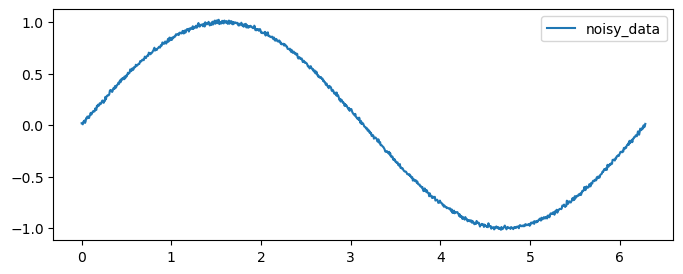

In [7]:
# plot the data
plt.figure(figsize=(8, 3))
plt.plot(t, x[0, 0, :], label='noisy_data', alpha=1)
plt.legend()
plt.show()

In [8]:
from torch.distributions import Normal
from torch.nn import functional as F

In [9]:
def gaussian_kernel_1d(sigma: float, num_sigmas: float = 3.) -> torch.Tensor:
    radius = (num_sigmas * sigma) // 1
    support = torch.arange(-radius, radius + 1, dtype=torch.float)
    kernel = Normal(loc=0, scale=sigma).log_prob(support).exp_()
    # Ensure kernel weights sum to 1, so that image brightness is not altered
    return kernel.mul_(1 / kernel.sum()).reshape(1, 1, -1)

In [10]:
SIGMA_1 = 10
kernel = gaussian_kernel_1d(SIGMA_1, 3)
kernel.shape

torch.Size([1, 1, 61])

In [11]:
lim = kernel.shape.numel()//2
pad = (lim, lim)

In [12]:
# apply padding
x_pad = F.pad(x, pad, mode='replicate')
# apply smoothing
x_smooth = F.conv1d(x_pad, kernel)

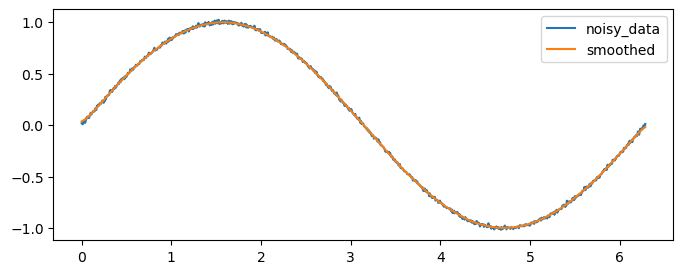

In [13]:
# plot the data
plt.figure(figsize=(8, 3))
plt.plot(t, x[0, 0, :], label='noisy_data', alpha=1)
plt.plot(t, x_smooth[0, 0, :], label='smoothed', alpha=1)  
plt.legend()
plt.show()

In [14]:
# pad the data x_smooth with a 1 on the left
pad = (1, 0)
x_smooth_pad = F.pad(x_smooth, pad, mode='replicate')
x_clean_pad = F.pad(x_clean, pad, mode='replicate')

In [15]:
# compute the difference
x_smooth_diff = x_smooth_pad.diff()
x_clean_diff = x_clean_pad.diff()

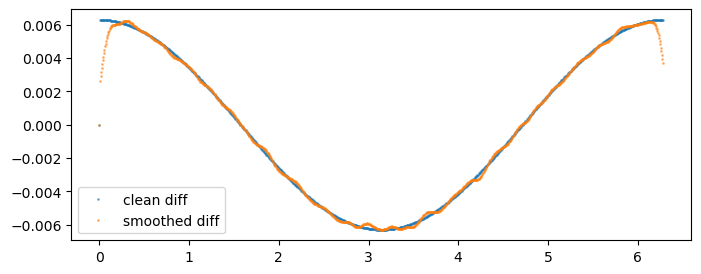

In [16]:
plt.figure(figsize=(8, 3))
plt.plot(t, x_clean_diff[0, 0, :], 'o', label='clean diff', markersize=1, alpha=0.5)
plt.plot(t, x_smooth_diff[0, 0, :], 'o', label='smoothed diff', markersize=1, alpha=0.5)
plt.legend()
plt.show()

## Double smoothing for the $2^{nd}$ derivative

In [17]:
SIGMA_2 = 30
kernel = gaussian_kernel_1d(SIGMA_2, 3)
lim = kernel.shape.numel()//2
pad = (lim, lim)
x_smooth_diff_pad = F.pad(x_smooth_diff, pad, mode='replicate')
x_smooth_diff_smooth = F.conv1d(x_smooth_diff_pad, kernel)

In [18]:
pad = (1, 0)
x_clean_diff_pad = F.pad(x_clean_diff, pad, mode='replicate')
x_smooth_diff_pad = F.pad(x_smooth_diff, pad, mode='replicate')
x_smooth_diff_smooth_pad = F.pad(x_smooth_diff_smooth, pad, mode='replicate')

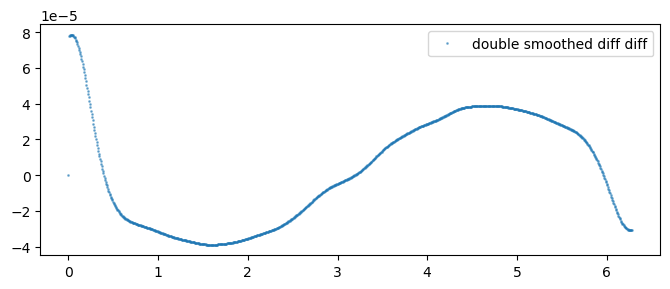

In [19]:
# x_clean_diff_diff = x_clean_diff_pad.diff()
# x_smooth_diff_diff = x_smooth_diff_pad.diff()
x_smooth_diff_smooth_diff = x_smooth_diff_smooth_pad.diff()


plt.figure(figsize=(8, 3))
# plt.plot(t, x_clean_diff_diff[0,0,:], 'o', label='clean diff diff', markersize=1, alpha=0.5)
# plt.plot(t, x_smooth_diff_diff[0,0,:], 'o', label='single smoothed diff diff', markersize=1, alpha=0.5)
plt.plot(t, x_smooth_diff_smooth_diff[0,0,:], 'o', 
         label='double smoothed diff diff', markersize=1, alpha=0.5)
plt.legend()
plt.show()

# Spline Smoothing

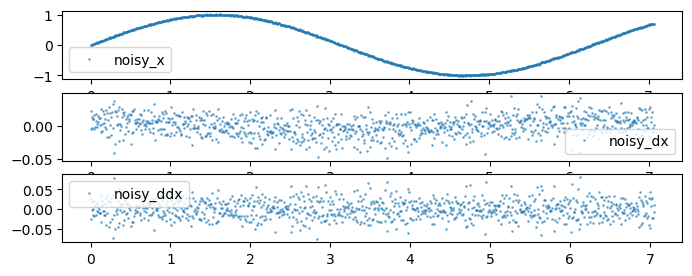

In [24]:
# reload noisy data
t = torch.linspace(0, 2.25 * np.pi, 1000)
x = torch.sin(t) + torch.randn_like(t) * 0.01

dx_noisy = x.diff()
ddx_noisy = dx_noisy.diff()

plt.figure(figsize=(8, 3))
# 3 subplots
plt.subplot(3, 1, 1)
plt.plot(t, x, 'o', label='noisy_x', markersize=1, alpha=0.5)
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(t[:-1], dx_noisy, 'o', label='noisy_dx', markersize=1, alpha=0.5)
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(t[:-2], ddx_noisy, 'o', label='noisy_ddx', markersize=1, alpha=0.5)
plt.legend()
plt.show()

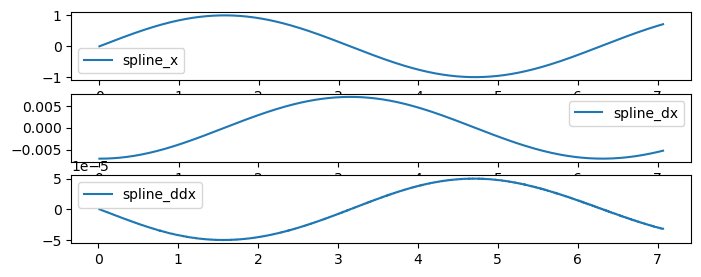

In [33]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline

degree = 6
n_knots = 5
spline_model = make_pipeline(SplineTransformer(n_knots=n_knots, degree=degree, extrapolation='continue'), Ridge(alpha=1e-3))
spline_model.fit(t.reshape(-1, 1), x.reshape(-1, 1))

x_spline = spline_model.predict(t.reshape(-1, 1))
# take the derivative of the spline
dx_spline = x_spline[:-1] - x_spline[1:]
# take the derivative of the derivative of the spline
ddx_spline = dx_spline[:-1] - dx_spline[1:]

plt.figure(figsize=(8, 3))
plt.subplot(3, 1, 1)
plt.plot(t, x_spline, label='spline_x', alpha=1)
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(t[1:], dx_spline, label='spline_dx', alpha=1)
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(t[2:], ddx_spline, label='spline_ddx', alpha=1)
plt.legend()
plt.show()
